### Python imports

In [1]:
import xarray as xr
import os
import glob
import numpy as np
import pandas as pd
from tqdm import tqdm
from time import sleep
from functools import partial
import time
import numcodecs
import zarr
import dask

### Inputs

In [2]:
import io
import boto3

def read_dataset_inmemory(s3_path: str) -> xr.Dataset:
    """Read a NetCDF as an XArray using in-memory data"""
    try:
        with io.BytesIO() as inmemoryfile:
            # Use boto to download a file to memory
            s3 = boto3.client("s3")
            bucket, key = s3_path.replace("s3://", "").split("/", 1)
            s3.download_fileobj(bucket, key, inmemoryfile)
            inmemoryfile.seek(0)

            return xr.open_dataset(inmemoryfile)
    except ValueError as e:
        print(f"Failed to open the file with error: {e}")
        return None

### Argo Processor

**Source notebook**
https://medium.com/@nicolasmortimer/argo-floats-zarr-and-pangeo-d74fc6d4ce35

*Written by Nicolas Mortimer*

In [3]:
data_types ={'CONFIG_MISSION_NUMBER':'float32','CYCLE_NUMBER':'float32','DATA_CENTRE':'|U2','DATA_MODE':'|U1',
             'DATA_STATE_INDICATOR':'|U4','DC_REFERENCE':'|U32','DIRECTION':'|U1','FIRMWARE_VERSION':'|U32',
             'FLOAT_SERIAL_NO':'|U32','JULD':'float32','JULD_LOCATION':'float32','JULD_QC':'|U1','LATITUDE':'float32',
             'LONGITUDE':'float32','PI_NAME':'|U64','PLATFORM_NUMBER':'|U8','PLATFORM_TYPE':'|U32','POSITIONING_SYSTEM':'|U8',
             'POSITION_QC':'|U1','PRES':'float32','PRES_ADJUSTED':'float32','PRES_ADJUSTED_ERROR':'float32',
             'PRES_ADJUSTED_QC':'|U1','PRES_QC':'|U1','PROFILE_PRES_QC':'|U1','PROFILE_PSAL_QC':'|U1','PROFILE_TEMP_QC':'|U1',
             'PROJECT_NAME':'|U64','PSAL':'float32','PSAL_ADJUSTED':'float32','PSAL_ADJUSTED_ERROR':'float32',
             'PSAL_ADJUSTED_QC':'|U1','PSAL_QC':'|U1','TEMP':'float32','TEMP_ADJUSTED':'float32','TEMP_ADJUSTED_ERROR':'float32',
             'TEMP_ADJUSTED_QC':'|U1','TEMP_QC':'|U1','VERTICAL_SAMPLING_SCHEME':'|U256','WMO_INST_TYPE':'|U4'}

data_levels =['PRES','PRES_ADJUSTED','PRES_ADJUSTED_ERROR','PRES_ADJUSTED_QC','PRES_QC','PSAL','PSAL_ADJUSTED',
              'PSAL_ADJUSTED_ERROR','PSAL_ADJUSTED_QC','PSAL_QC','TEMP','TEMP_ADJUSTED','TEMP_ADJUSTED_ERROR',
              'TEMP_ADJUSTED_QC','TEMP_QC']

def process_mf(dsinput,levels,data_types=data_types,data_levels=data_levels):
    ds = xr.Dataset()
    dims =('N_PROF','N_LEVELS')
    # The number of profiles is indicated by the N_PROF dimension
    # The number of pressure levels is indicated by the N_LEVELS dimension
    pading =xr.DataArray(np.ones((len(dsinput.N_PROF),levels-len( dsinput.N_LEVELS))) *np.nan,dims=dims)
    pad_qc = xr.DataArray(np.chararray((len(dsinput.N_PROF),levels-len( dsinput.N_LEVELS))),dims=dims)
    pad_qc[:] = b' '
    for varname in data_types.keys():
        if varname in dsinput.data_vars:
            da = dsinput[varname]
            if 'N_LEVELS' in da.dims:   
                if varname in dsinput.data_vars:
                    if varname.endswith('QC'):
                        da = xr.concat([dsinput[varname],pad_qc],dim='N_LEVELS').astype(data_types[varname])
                    else:
                        da = xr.concat([dsinput[varname],pading],dim='N_LEVELS').astype(data_types[varname])
            else:
                da = dsinput[varname].astype(data_types[varname])
        else:
            if varname in data_levels:
                if data_types[varname]=='float32':
                    da = xr.DataArray(np.ones((len(dsinput.N_PROF),levels), dtype='float32')*np.nan , name=varname, dims=['N_PROF','N_LEVELS'])
                else:
                    p=np.chararray((len(dsinput.N_PROF),levels))
                    p[:]=b'0'
                    da = xr.DataArray(p.astype(data_types[varname]), name=varname, dims=['N_PROF','N_LEVELS'])
            else:
                if data_types[varname]=='float32':
                    da = xr.DataArray(np.ones(len(dsinput.N_PROF), dtype="float32")*np.nan , name=varname, dims=['N_PROF'])
                else:
                    p=np.chararray((len(dsinput.N_PROF)))
                    p[:]=b'0'
                    da = xr.DataArray(p.astype(data_types[varname]), name=varname, dims=['N_PROF'])
        if not ('HISTORY' in varname) and ('N_CALIB' not in da.dims) and ('N_PARAM' not in da.dims) and  ('N_PROF' in da.dims):
                ds[varname]= da
    return ds.chunk({'N_LEVELS':levels})

def process_float(s3_uri):
    preproc = partial(process_mf,levels=3000)
    file = read_dataset_inmemory(s3_uri)
    data = preproc(file)
    return data

In [4]:
def export_zarr(store, dataset, overwrite):
    if overwrite:
        dataset.to_zarr(store, mode='w', consolidated=True)
    else:
        dataset.to_zarr(store, mode='a', append_dim='N_PROF', consolidated=True)

### Generate dataset and export to Zarr

In [5]:
%%time
import s3fs
s3 = s3fs.S3FileSystem(anon=False)

input_paths = []
# glob_result = s3.glob('s3://imos-data/IMOS/Argo/dac/csiro/7900324/profiles/*.nc')
glob_result = s3.glob('s3://imos-data/IMOS/Argo/dac/csiro/7900324/profiles/*.nc')
input_paths.extend(['s3://' + path for path in glob_result])
store_path = 's3://imos-data-pixeldrill/vhnguyen/emr/argo/temp/temp.zarr'
# store_path = './emr/argo.zarr/'
emr_dns = 'localhost'

CPU times: user 197 ms, sys: 16.5 ms, total: 213 ms
Wall time: 3.28 s


### Using Dask

In [6]:
import dask
from dask.distributed import Client, LocalCluster
with dask.config.set({'temporary_directory': '/home/vietnguyen/dask/'}):
    # set up cluster and workers
    cluster = LocalCluster(n_workers=3, memory_limit='4GB', processes=True, 
                           threads_per_worker=2, dashboard_address=':34273', ip=emr_dns)
    client = Client(address=cluster.scheduler_address)

print(f'http://{emr_dns}'+':{port}/status'.format(port=client.scheduler_info().get('services').get('dashboard')))

http://localhost:34273/status


In [7]:
input_paths = input_paths[:2]
start_time = time.time()
store= s3fs.S3Map(root=f'{store_path}', s3=s3, check=False)

futures = []
print('************ Initilising futures ************')
for i in tqdm(range(len(input_paths))):
    futures.append(client.submit(process_float, input_paths[i], retries=10))

print('************** Processing Zarr **************')

zarrs = client.gather(futures)
ds = xr.concat(zarrs,dim='N_PROF',coords='minimal',compat='override',combine_attrs='override', fill_value='')

z = ds.to_zarr(store, mode='w', compute=False, consolidated=True)
z.compute()

print('*********************************************')
print("---------- Total: %.2f seconds ----------" % (time.time() - start_time))
print('*********************************************')

************ Initilising futures ************


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 14.33it/s]

************** Processing Zarr **************


*********************************************
---------- Total: 71.32 seconds ----------
*********************************************


### Open Zarr

In [8]:
%%time
store_path = 's3://imos-data-pixeldrill/vhnguyen/emr/argo/temp/temp.zarr'
data = xr.open_zarr(store_path)
data

CPU times: user 220 ms, sys: 18.1 ms, total: 238 ms
Wall time: 1.61 s


<xarray.Dataset>
Dimensions:                   (N_PROF: 2, N_LEVELS: 3000)
Dimensions without coordinates: N_PROF, N_LEVELS
Data variables: (12/40)
    CONFIG_MISSION_NUMBER     (N_PROF) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    CYCLE_NUMBER              (N_PROF) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    DATA_CENTRE               (N_PROF) <U2 dask.array<chunksize=(1,), meta=np.ndarray>
    DATA_MODE                 (N_PROF) <U1 dask.array<chunksize=(1,), meta=np.ndarray>
    DATA_STATE_INDICATOR      (N_PROF) <U4 dask.array<chunksize=(1,), meta=np.ndarray>
    DC_REFERENCE              (N_PROF) <U32 dask.array<chunksize=(1,), meta=np.ndarray>
    ...                        ...
    TEMP_ADJUSTED             (N_PROF, N_LEVELS) float32 dask.array<chunksize=(1, 3000), meta=np.ndarray>
    TEMP_ADJUSTED_ERROR       (N_PROF, N_LEVELS) float32 dask.array<chunksize=(1, 3000), meta=np.ndarray>
    TEMP_ADJUSTED_QC          (N_PROF, N_LEVELS) <U1 dask.array<chunksize=(1, 3000), meta=np.ndarray>
    TEMP_QC                   (N_PROF, N_LEVELS) <U1 dask.array<chunksize=(1, 3000), meta=np.ndarray>
    VERTICAL_SAMPLING_SCHEME  (N_PROF) <U256 dask.array<chunksize=(1,), meta=np.ndarray>
    WMO_INST_TYPE             (N_PROF) <U4 dask.array<chunksize=(1,), meta=np.ndarray>

CPU times: user 891 ms, sys: 79 ms, total: 970 ms
Wall time: 3.36 s


Text(0.5, 1.0, 'Argo Float #7900324 on 2011-03-08T10:38:25Z')

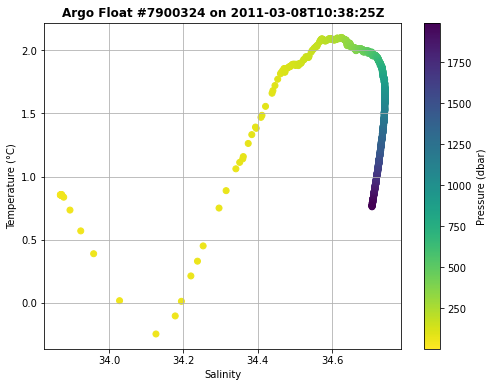

In [9]:
%%time
import matplotlib.pyplot as plt
from datetime import datetime

def np_dt64_to_dt(in_datetime: np.datetime64) -> str:
    """Convert numpy datetime64 to datetime"""
    dt = datetime.fromtimestamp(in_datetime.astype(int) / 1e9)
    return dt.strftime("%Y-%m-%dT%H:%M:%SZ")

plt.figure(figsize=(8,6))

nprof = round(len(input_paths) / 2) #Selected profile
plt.scatter(data.PSAL_ADJUSTED[nprof], data.TEMP_ADJUSTED[nprof], c=data.PRES_ADJUSTED[nprof], cmap='viridis_r')
plt.xlabel('Salinity');
plt.ylabel('Temperature (°C)')

cbh = plt.colorbar();
cbh.set_label('Pressure (dbar)')

plt.grid()
plt.title('Argo Float #%d on %s' % (data.PLATFORM_NUMBER[nprof].values, np_dt64_to_dt(data.JULD[nprof].values)), fontweight='bold');

In [10]:
# cluster.close()
# client.close()